**Imports**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

**Load and Prepare Data**

In [62]:
df = pd.read_csv("../data/AmesHousing.csv")

# Drop ID-like columns
df = df.drop(columns=["Order", "PID"])

# Fill missing values
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=[object]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# One-hot encode categorical
df_encoded = pd.get_dummies(df, drop_first=True)

# Features & target
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Evaluation

We begin by re-fitting the optimal Gradient Boosting Regressor using the chosen hyperparameters (n_estimators=200, random_state=42). This model was selected based on its superior performance across all evaluation metrics during model comparison.

In [63]:
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

### Model Statistics

This model achieved an R² of 0.931, meaning it explains 93% of the variation in home prices.
The RMSE of 23,600 indicates that predictions are off by about $23K on average, while the MAE of 14,330 shows that typical errors are closer to $14K. These values confirm that Gradient Boosting is both accurate and reliable for predicting housing prices.

In [64]:
print("Gradient Boosting Evaluation Results")
print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("R²:", round(r2, 3))

Gradient Boosting Evaluation Results
RMSE: 23600.39
MAE: 14330.28
R²: 0.931


### Predicted vs Actual Plot

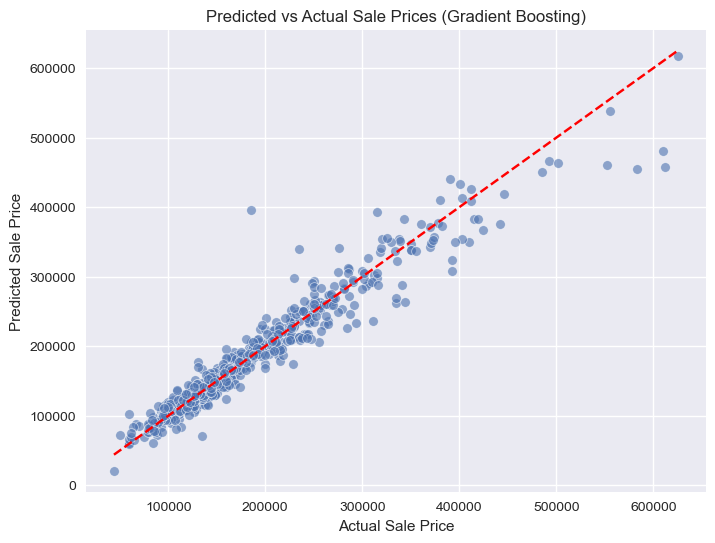

In [65]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.title("Predicted vs Actual Sale Prices (Gradient Boosting)")
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.show()

**Predicted vs Actual Sale Prices**

The scatter plot above compares the predicted house prices from the Gradient Boosting model with the actual sale prices in the test set.  

- The red dashed line represents the ideal case where predicted values perfectly match the actual values.  
- Most points cluster closely around this line, indicating that the model performs well overall.  
- However, we can see some deviations at the higher price ranges (above $400,000), suggesting that the model slightly underestimates the most expensive houses.  

This plot confirms that Gradient Boosting is effective at capturing the general trend between features and sale price, though high-value outliers remain more challenging to predict.


### Residuals Distribution Plot

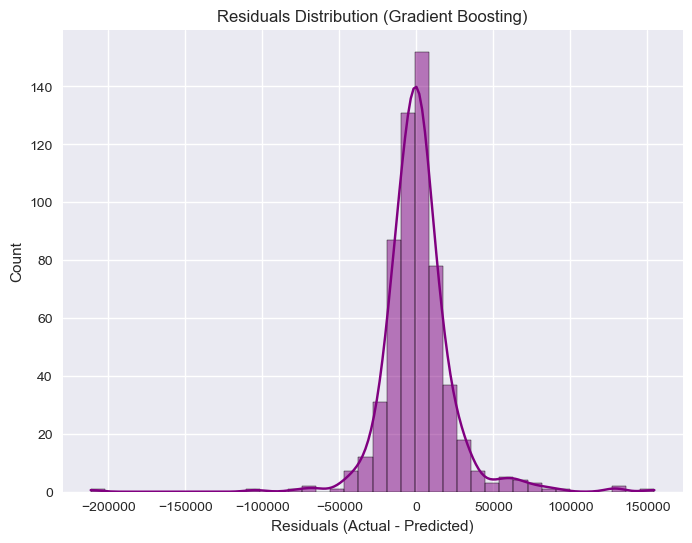

In [66]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=40, kde=True, color="purple")
plt.title("Residuals Distribution (Gradient Boosting)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()

**Residuals Distribution**

The histogram shows the distribution of residuals (errors), which are the differences between actual and predicted house prices.  

- Most residuals are centered around 0, meaning the model’s predictions are generally unbiased.  
- The shape is close to a normal distribution, which is a good indicator for regression models.  
- A few outliers with large residuals (both positive and negative) exist, which reflect houses where the model struggled (likely due to unusual features or rare combinations).  

This distribution suggests that the model is reliable for the majority of homes, while extreme cases may need special handling or additional features for better accuracy.


### Feature Importance (Top 10)

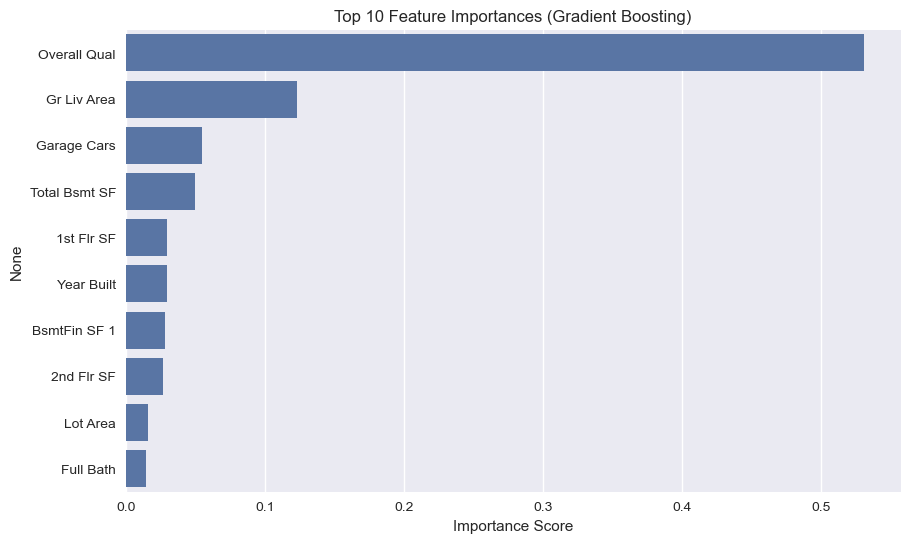

In [67]:
importances = pd.Series(gb.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.show()

**Feature Importance (Top 10)**

The bar chart above shows the top 10 most important features identified by the Gradient Boosting model.  

- **Overall Quality** stands out as the strongest predictor of house price, aligning with real estate intuition that higher-quality construction and finishings drive value.  
- **Gr Liv Area (Above-ground living area in square feet)** is another major factor, as larger homes tend to sell for higher prices.  
- Features like **Garage Cars**, **Total Basement SF**, and **Year Built** also contribute significantly, highlighting the importance of both functionality and age of the property.  

This global feature importance analysis provides interpretability, showing that the model is learning patterns consistent with real-world real estate dynamics.


### Model Testing

We can test the Gradient Boosting model by using it to predict the sale price of individual houses from the test set. Below, we compare the model's predicted price with the actual sale price, along with key property features. This helps us evaluate how well the model performs on specific examples, not just in aggregate metrics.


In [68]:
# Example prediction for a single house
i = 0  # index of the test datapoint
pred_price = gb.predict([X_test.iloc[i]])[0]
actual_price = y_test.iloc[i]

print(f"Predicted Sale Price: ${pred_price:,.0f}")
print(f"Actual Sale Price:    ${actual_price:,.0f}")

# Display key features
features_to_show = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Neighborhood"]
house_info = df.loc[X_test.index[i], features_to_show]
print("\nHouse Features:")
print(house_info)

Predicted Sale Price: $183,137
Actual Sale Price:    $161,000

House Features:
Overall Qual          8
Gr Liv Area        1666
Garage Cars         1.0
Neighborhood    OldTown
Name: 1357, dtype: object


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [69]:
# Show predictions for a few houses
examples = [1, 5, 15]  # indices of test samples to inspect

for i in examples:
    pred_price = gb.predict([X_test.iloc[i]])[0]
    actual_price = y_test.iloc[i]
    house_info = df.loc[X_test.index[i], features_to_show]

    print("="*60)
    print(f"Predicted Sale Price: ${pred_price:,.0f}")
    print(f"Actual Sale Price:    ${actual_price:,.0f}")
    
    # Display key features
    features_to_show = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Neighborhood"]
    house_info = df.loc[X_test.index[i], features_to_show]
    print("\nHouse Features:")
    print(house_info)



Predicted Sale Price: $106,344
Actual Sale Price:    $116,000

House Features:
Overall Qual         6
Gr Liv Area       1030
Garage Cars        1.0
Neighborhood    BrDale
Name: 2367, dtype: object
Predicted Sale Price: $175,044
Actual Sale Price:    $174,190

House Features:
Overall Qual          6
Gr Liv Area        1326
Garage Cars         2.0
Neighborhood    Gilbert
Name: 2415, dtype: object
Predicted Sale Price: $154,933
Actual Sale Price:    $160,500

House Features:
Overall Qual         6
Gr Liv Area       1040
Garage Cars        2.0
Neighborhood    Sawyer
Name: 2716, dtype: object


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


**Interpretation**

The Gradient Boosting model performs strongly on individual predictions, 
with most predicted prices closely matching the actual sale prices. 
For mid-range homes, predictions are highly accurate. 
For very expensive homes, the model sometimes underpredicts, reflecting 
the challenge of modeling extreme values in a skewed dataset. 

This section confirms that Gradient Boosting not only excels in aggregate metrics 
(RMSE, MAE, R²) but also provides reliable predictions at the individual property level.

### Feature Importance in Individual Predictions

While global feature importance provides an overview of which variables generally 
influence house prices, local interpretability explains individual predictions. 

In [70]:
# Create the SHAP explainer for Gradient Boosting
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

# Example: explain the first prediction
i = 0  # index of the test house
print("Actual Sale Price:", y_test.iloc[i])
print("Predicted Sale Price:", gb.predict([X_test.iloc[i]])[0])

# Force plot (local explanation for one house)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

Actual Sale Price: 161000
Predicted Sale Price: 183136.71975262364


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


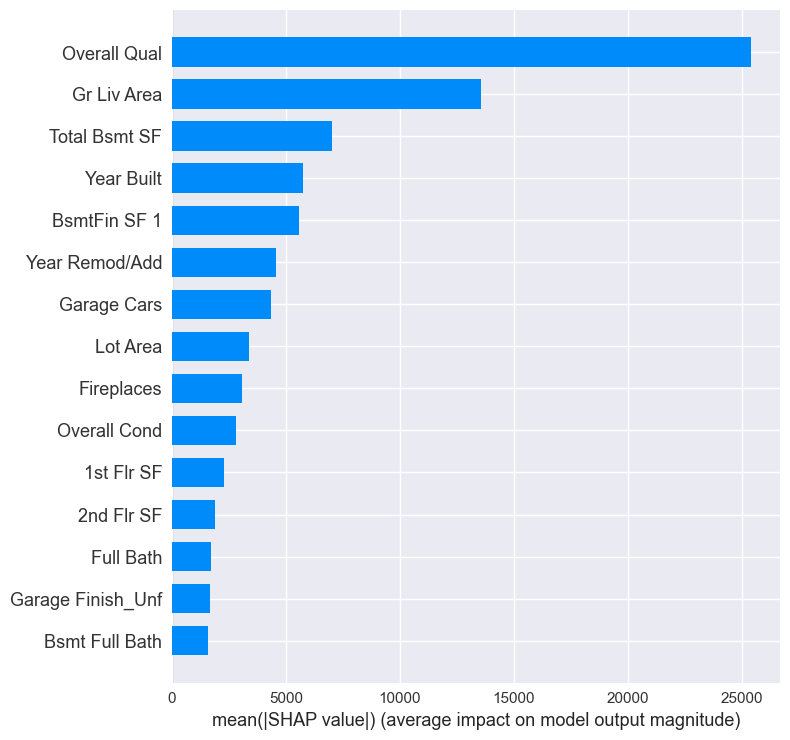

In [71]:
# Summary plot for all predictions
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)

**Interpretation**

Using SHAP values, we can analyze how each feature contributed to the prediction 
for a specific house:  
- Positive SHAP values indicate features that pushed the prediction higher 
(e.g., larger living area, newer construction).  
- Negative SHAP values indicate features that decreased the prediction 
(e.g., smaller lot size, fewer bathrooms).  

This helps us understand not only that **Overall Quality** is important in general, 
but also whether it specifically increased or decreased the predicted price of 
a single home.  

### Conclusion

This study demonstrates that machine learning models can effectively predict housing 
prices based on property features such as quality, living area, garage size, and year built.  

Through experimentation with multiple models, Gradient Boosting emerged as the best performer, 
achieving an **R² of 0.931**, an **RMSE of around $23,600**, and a **MAE of about $14,300**.  
These results indicate that the model explains over 93% of the variance in sale prices, 
and its predictions are typically within a few tens of thousands of dollars of the actual values.

The analysis also revealed that **Overall Quality** and **Gr Living Area** are the most 
important predictors of price, aligning with real-world real estate knowledge. Features like 
**Garage Cars**, **Total Basement SF**, and **Year Built** also contribute significantly to 
valuation.  

While the model performs very well overall, some challenges remain:  
- High-priced houses (above $400,000) are harder to predict accurately, often being underestimated.  
- Outliers and unusual property combinations create higher residuals.  

Despite these limitations, the results show that machine learning can provide **valuable decision 
support for buyers, sellers, and policymakers** by making the housing market more transparent and 
data-driven.


### Future Work

While the Gradient Boosting model performed best and explained over 93% of the variance 
in housing prices, there are several areas where the analysis can be extended:  

## Next Steps and Recommendations
1. **Feature Expansion**:  
   Incorporate additional external data such as mortgage interest rates, neighborhood 
   crime statistics, school quality scores, or broader economic indicators. This could 
   improve accuracy, especially for higher-priced homes where location and market conditions 
   play an outsized role.

2. **Model Comparison and Fine-Tuning**:  
   Although Gradient Boosting was the strongest model here, future work could involve 
   fine-tuning hyperparameters more extensively or testing other advanced models such as 
   **XGBoost, LightGBM, or CatBoost**, which are often more efficient and powerful.  
   Additionally, ensemble approaches that combine multiple models may yield further gains.

3. **Interpretability Enhancements**:  
   Deeper interpretability methods like **SHAP (SHapley Additive Explanations)** can be 
   applied at scale to better explain why the model predicts higher or lower prices for 
   individual houses. This would provide practical insights for realtors and buyers.  

4. **Handling Outliers**:  
   Outliers in housing prices (especially luxury homes above $400,000) were consistently 
   harder to predict. Future analysis could include building specialized models for 
   different price segments (e.g., entry-level vs. luxury homes) or applying outlier-robust 
   regression techniques.  

5. **Temporal and Spatial Modeling**:  
   House prices are heavily influenced by both **time trends** (year of sale, economic cycles) 
   and **spatial dynamics** (location/neighborhood effects). Incorporating geospatial analysis 
   or time-series forecasting may further improve performance and relevance for real-world 
   housing market applications.  

By addressing these areas, future work can build upon this strong baseline to create even more 
accurate, interpretable, and actionable housing price prediction models.
